## Data Preprocessing 

In [31]:
# import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams["font.sans-serif"] = ["SimHei"]
plt.rcParams["axes.unicode_minus"] = False  # 正常显示负号
import seaborn as sns

In [32]:
# Load the data
# 加載JSON格式的資料
import json

# 加載context.json
with open('context.json', 'r', encoding='utf-8') as f:
    context = json.load(f)

# 加載train.json
with open('train.json', 'r', encoding='utf-8') as f:
    train_data = json.load(f)

# 加載valid.json
with open('valid.json', 'r', encoding='utf-8') as f:
    valid_data = json.load(f)

# 加載test.json
with open('test.json', 'r', encoding='utf-8') as f:
    test_data = json.load(f)


In [33]:
# Check data 
# 檢查context數量與範例
print(f"Context段落總數: {len(context)}")
print(f"範例段落: {context[0][:50]}")  # 顯示第一篇文章的前50個字

# 檢查train資料的數量與結構
print(f"Train資料總數: {len(train_data)}")
print(f"範例數據: {train_data[0]}")


Context段落總數: 9013
範例段落: 鼓是一種打擊樂器，也是一種通訊工具，非洲某些部落用以傳達信息，中國古代軍隊用以發號施令。堅固的女的一
Train資料總數: 21714
範例數據: {'id': '593f14f960d971e294af884f0194b3a7', 'question': '舍本和誰的數據能推算出連星的恆星的質量？', 'paragraphs': [2018, 6952, 8264, 836], 'relevant': 836, 'answer': {'text': '斯特魯維', 'start': 108}}


In [34]:
# 段落長度分佈
paragraph_lengths = [len(paragraph) for paragraph in context]
print(f"段落的平均長度: {np.mean(paragraph_lengths)}")
print(f"段落的最長長度: {np.max(paragraph_lengths)}")
print(f"段落的最短長度: {np.min(paragraph_lengths)}")

# 問題字數分佈
question_lengths = [len(data['question']) for data in train_data]
print(f"問題的平均長度: {np.mean(question_lengths)}")
print(f"問題的最大長度: {np.max(question_lengths)}")
print(f"問題的最小長度: {np.min(question_lengths)}")


段落的平均長度: 437.23488294685455
段落的最長長度: 1765
段落的最短長度: 166
問題的平均長度: 20.85290595928894
問題的最大長度: 222
問題的最小長度: 4


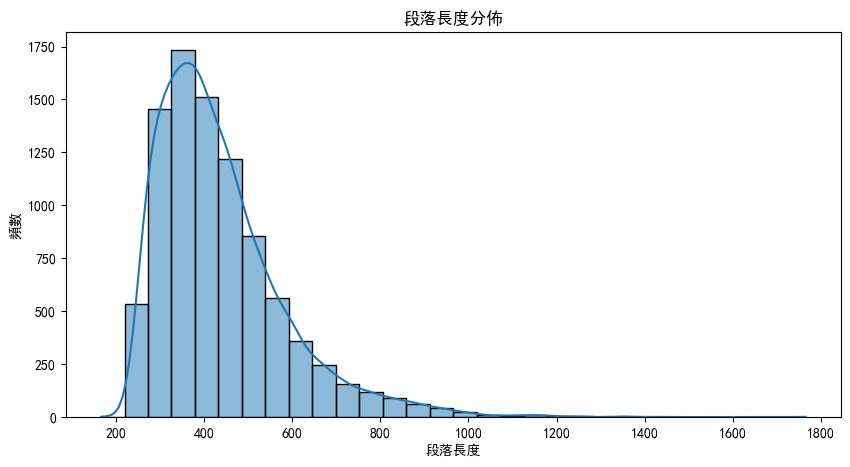

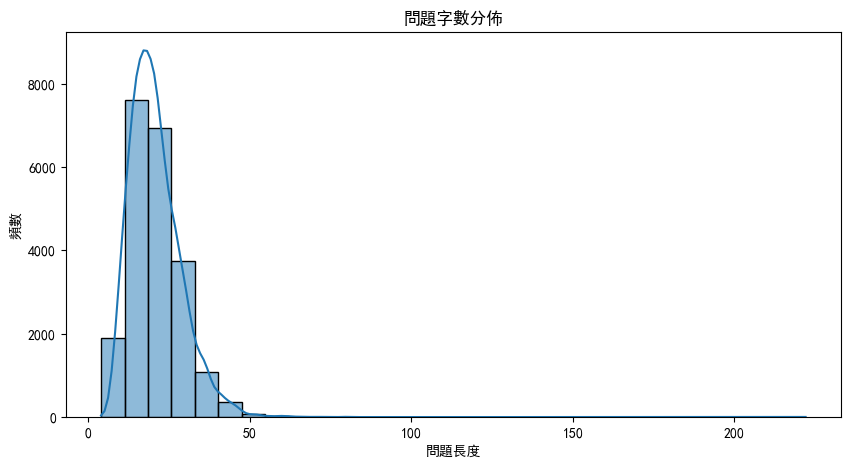

In [35]:
# 可視化段落長度分佈
plt.figure(figsize=(10, 5))
sns.histplot(paragraph_lengths, bins=30, kde=True)
plt.title('段落長度分佈')
plt.xlabel('段落長度')
plt.ylabel('頻數')
plt.show()

# 可視化問題字數分佈
plt.figure(figsize=(10, 5))
sns.histplot(question_lengths, bins=30, kde=True)
plt.title('問題字數分佈')
plt.xlabel('問題長度')
plt.ylabel('頻數')
plt.show()


## Train Model 1. 

In [86]:
import torch
from transformers import AutoTokenizer, AutoModelForMultipleChoice, AdamW, get_scheduler
from torch.utils.data import DataLoader

import json
from tqdm import tqdm


In [87]:
# 加載 context 和 train 數據
with open('context.json', 'r', encoding='utf-8') as f:
    contexts = json.load(f)

with open('train.json', 'r', encoding='utf-8') as f:
    train_data = json.load(f)

# 將數據轉換為 SWAG 格式的結構
def convert_to_swag_format(train_data, contexts):
    input_data = []
    for item in train_data:
        question = item['question']
        paragraphs = item['paragraphs']  # 文章索引列表
        relevant_paragraph_index = item['relevant']
        
        # 構建選項，並確定正確答案的位置
        choices = [contexts[idx] for idx in paragraphs]
        correct_choice_idx = paragraphs.index(relevant_paragraph_index)
        
        input_data.append({
            'question': question,
            'choices': choices,
            'label': correct_choice_idx  # 正確答案的索引
        })
    return input_data

train_dataset = convert_to_swag_format(train_data, contexts)

In [88]:
train_dataset[0]

{'question': '舍本和誰的數據能推算出連星的恆星的質量？',
 'choices': ['1930年，印度物理學家蘇布拉馬尼揚·錢德拉塞卡根據廣義相對論計算出質量大於1.4倍太陽質量的非轉動星體會因重力塌縮成為電子簡併態。愛丁頓雖然在理論上支持黑洞存在的可能性，但同時認為錢德拉塞卡的觀點事實上不能成立，他認為「應當有某種自然定律阻止恆星出現這種荒唐的行為」。當時的物理學家如波耳、亨利·羅素等人都贊同錢德拉塞卡的理論，但出於愛丁頓聲望的原因，他們並沒有公開對錢德拉塞卡表示支持。不過從某種意義上說，愛丁頓也是正確的，當恆星質量大於錢德拉塞卡極限後，確實仍然會有中子簡併壓力阻止恆星繼續塌縮。到了1939年，美國物理學家羅伯特·歐本海默等人推算了這種情形的恆星質量上限，這個極限被稱作托爾曼-歐本海默-沃爾科夫極限。當今的天體物理學家普遍認為，除非有如未知的夸克簡併壓力一類因素的存在，質量大於托爾曼-歐本海默-沃爾科夫極限的恆星將最終會塌縮為錢德拉塞卡所預言的黑洞。即使如此，史瓦西解作為當時能夠描述黑洞行為的唯一精確解，由於具有一些讓人看似不大優美的性質以及難以與實驗觀測相聯繫，一直沒有進入主流物理學研究的視野，關於黑洞的理論乃至整個廣義相對論領域的研究由此擱置了二十年之久。',
  '心理學是否為自然科學的範圍，目前也尚存爭議，一般較廣為接受的說法是心理學同時包含在自然科學與社會科學的範疇之中。自然科學的根本目的在於尋找隱藏在自然現象背後的規律，但是自然科學的工作尚不包括研究為什麼會存在這些規律。自然科學認為超自然的、隨意的和自相矛盾的現象是不存在的。自然科學的最重要的兩個支柱是觀察和邏輯推理。由對自然的觀察和邏輯推理自然科學可以引導出大自然中的規律。假如觀察的現象與規律的預言不同，那麼要麼是因為觀察中有錯誤，要麼是因為至此為止被認為是正確的規律是錯誤的。一個超自然因素是不存在的。',
  '這是一個長久以來就存在的假設，大多數的恆星都是長期處在特定重力場的多星或聯星系統。特別是許多大質量的歐和逼型恆星，有80%被認為是多星系統的一部分。然而，質量越低的恆星，單獨存在的比例顯然越高，只有25%的紅矮星被發現有伴星。因為85%的恆星是紅矮星，所以在銀河系內多數的恆星都是單獨誕生的。恆星在宇宙中的分布是不均勻的，並且通常都是成群的與星際間的氣體、塵埃一起存在於星系中

In [89]:
def show_one(example):
    print(f"question: {example['question']}")
    print(f"  A - {example['choices'][0]} ")
    print(f"  B - {example['choices'][1]} ")
    print(f"  C - {example['choices'][2]} ")
    print(f"  D - {example['choices'][3]} ")
    
    print(f"\nGround truth: option {['A', 'B', 'C', 'D'][example['label']]}")

In [92]:
show_one(train_dataset[0])

question: 舍本和誰的數據能推算出連星的恆星的質量？
  A - 1930年，印度物理學家蘇布拉馬尼揚·錢德拉塞卡根據廣義相對論計算出質量大於1.4倍太陽質量的非轉動星體會因重力塌縮成為電子簡併態。愛丁頓雖然在理論上支持黑洞存在的可能性，但同時認為錢德拉塞卡的觀點事實上不能成立，他認為「應當有某種自然定律阻止恆星出現這種荒唐的行為」。當時的物理學家如波耳、亨利·羅素等人都贊同錢德拉塞卡的理論，但出於愛丁頓聲望的原因，他們並沒有公開對錢德拉塞卡表示支持。不過從某種意義上說，愛丁頓也是正確的，當恆星質量大於錢德拉塞卡極限後，確實仍然會有中子簡併壓力阻止恆星繼續塌縮。到了1939年，美國物理學家羅伯特·歐本海默等人推算了這種情形的恆星質量上限，這個極限被稱作托爾曼-歐本海默-沃爾科夫極限。當今的天體物理學家普遍認為，除非有如未知的夸克簡併壓力一類因素的存在，質量大於托爾曼-歐本海默-沃爾科夫極限的恆星將最終會塌縮為錢德拉塞卡所預言的黑洞。即使如此，史瓦西解作為當時能夠描述黑洞行為的唯一精確解，由於具有一些讓人看似不大優美的性質以及難以與實驗觀測相聯繫，一直沒有進入主流物理學研究的視野，關於黑洞的理論乃至整個廣義相對論領域的研究由此擱置了二十年之久。 
  B - 心理學是否為自然科學的範圍，目前也尚存爭議，一般較廣為接受的說法是心理學同時包含在自然科學與社會科學的範疇之中。自然科學的根本目的在於尋找隱藏在自然現象背後的規律，但是自然科學的工作尚不包括研究為什麼會存在這些規律。自然科學認為超自然的、隨意的和自相矛盾的現象是不存在的。自然科學的最重要的兩個支柱是觀察和邏輯推理。由對自然的觀察和邏輯推理自然科學可以引導出大自然中的規律。假如觀察的現象與規律的預言不同，那麼要麼是因為觀察中有錯誤，要麼是因為至此為止被認為是正確的規律是錯誤的。一個超自然因素是不存在的。 
  C - 這是一個長久以來就存在的假設，大多數的恆星都是長期處在特定重力場的多星或聯星系統。特別是許多大質量的歐和逼型恆星，有80%被認為是多星系統的一部分。然而，質量越低的恆星，單獨存在的比例顯然越高，只有25%的紅矮星被發現有伴星。因為85%的恆星是紅矮星，所以在銀河系內多數的恆星都是單獨誕生的。恆星在宇宙中的分布是不均勻的，並且通常都是成群的與星際間的氣體、塵埃一起存在於星系中。一個典型的星系擁有

In [93]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained('bert-base-chinese', use_fast=True)

/Users/jason/miniconda3/envs/ADL/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [94]:
print(train_dataset[0]['choices'][1])
print(train_dataset[0]['question'])

心理學是否為自然科學的範圍，目前也尚存爭議，一般較廣為接受的說法是心理學同時包含在自然科學與社會科學的範疇之中。自然科學的根本目的在於尋找隱藏在自然現象背後的規律，但是自然科學的工作尚不包括研究為什麼會存在這些規律。自然科學認為超自然的、隨意的和自相矛盾的現象是不存在的。自然科學的最重要的兩個支柱是觀察和邏輯推理。由對自然的觀察和邏輯推理自然科學可以引導出大自然中的規律。假如觀察的現象與規律的預言不同，那麼要麼是因為觀察中有錯誤，要麼是因為至此為止被認為是正確的規律是錯誤的。一個超自然因素是不存在的。
舍本和誰的數據能推算出連星的恆星的質量？


In [95]:
tokenizer(train_dataset[0]['choices'][1], train_dataset[0]['question'])

{'input_ids': [101, 2552, 4415, 2119, 3221, 1415, 4158, 5632, 4197, 4906, 2119, 4638, 5061, 1752, 8024, 4680, 1184, 738, 2213, 2100, 4261, 6359, 8024, 671, 5663, 6733, 2451, 4158, 2970, 1358, 4638, 6303, 3791, 3221, 2552, 4415, 2119, 1398, 3229, 1259, 1419, 1762, 5632, 4197, 4906, 2119, 5645, 4852, 3298, 4906, 2119, 4638, 5061, 4539, 722, 704, 511, 5632, 4197, 4906, 2119, 4638, 3418, 3315, 4680, 4638, 1762, 3176, 2204, 2823, 7403, 5966, 1762, 5632, 4197, 4412, 6496, 5520, 2527, 4638, 6211, 2526, 8024, 852, 3221, 5632, 4197, 4906, 2119, 4638, 2339, 868, 2213, 679, 1259, 2886, 4777, 4955, 4158, 784, 7938, 3298, 2100, 1762, 6857, 763, 6211, 2526, 511, 5632, 4197, 4906, 2119, 6291, 4158, 6631, 5632, 4197, 4638, 510, 7401, 2692, 4638, 1469, 5632, 4685, 4757, 4688, 4638, 4412, 6496, 3221, 679, 2100, 1762, 4638, 511, 5632, 4197, 4906, 2119, 4638, 3297, 7028, 6206, 4638, 1060, 943, 3118, 3393, 3221, 6223, 2175, 1469, 6922, 6744, 2972, 4415, 511, 4507, 2205, 5632, 4197, 4638, 6223, 2175, 1469, 

In [78]:
# 先產生四個選項的 token
first_sentences = [train_dataset[0]['question']] * 4
print(first_sentences)

['舍本和誰的數據能推算出連星的恆星的質量？', '舍本和誰的數據能推算出連星的恆星的質量？', '舍本和誰的數據能推算出連星的恆星的質量？', '舍本和誰的數據能推算出連星的恆星的質量？']


In [76]:
ending_names = [0, 1, 2, 3]

# 取得選項的 token
second_sentences = train_dataset[0]["choices"]
print(second_sentences)

['1930年，印度物理學家蘇布拉馬尼揚·錢德拉塞卡根據廣義相對論計算出質量大於1.4倍太陽質量的非轉動星體會因重力塌縮成為電子簡併態。愛丁頓雖然在理論上支持黑洞存在的可能性，但同時認為錢德拉塞卡的觀點事實上不能成立，他認為「應當有某種自然定律阻止恆星出現這種荒唐的行為」。當時的物理學家如波耳、亨利·羅素等人都贊同錢德拉塞卡的理論，但出於愛丁頓聲望的原因，他們並沒有公開對錢德拉塞卡表示支持。不過從某種意義上說，愛丁頓也是正確的，當恆星質量大於錢德拉塞卡極限後，確實仍然會有中子簡併壓力阻止恆星繼續塌縮。到了1939年，美國物理學家羅伯特·歐本海默等人推算了這種情形的恆星質量上限，這個極限被稱作托爾曼-歐本海默-沃爾科夫極限。當今的天體物理學家普遍認為，除非有如未知的夸克簡併壓力一類因素的存在，質量大於托爾曼-歐本海默-沃爾科夫極限的恆星將最終會塌縮為錢德拉塞卡所預言的黑洞。即使如此，史瓦西解作為當時能夠描述黑洞行為的唯一精確解，由於具有一些讓人看似不大優美的性質以及難以與實驗觀測相聯繫，一直沒有進入主流物理學研究的視野，關於黑洞的理論乃至整個廣義相對論領域的研究由此擱置了二十年之久。', '心理學是否為自然科學的範圍，目前也尚存爭議，一般較廣為接受的說法是心理學同時包含在自然科學與社會科學的範疇之中。自然科學的根本目的在於尋找隱藏在自然現象背後的規律，但是自然科學的工作尚不包括研究為什麼會存在這些規律。自然科學認為超自然的、隨意的和自相矛盾的現象是不存在的。自然科學的最重要的兩個支柱是觀察和邏輯推理。由對自然的觀察和邏輯推理自然科學可以引導出大自然中的規律。假如觀察的現象與規律的預言不同，那麼要麼是因為觀察中有錯誤，要麼是因為至此為止被認為是正確的規律是錯誤的。一個超自然因素是不存在的。', '這是一個長久以來就存在的假設，大多數的恆星都是長期處在特定重力場的多星或聯星系統。特別是許多大質量的歐和逼型恆星，有80%被認為是多星系統的一部分。然而，質量越低的恆星，單獨存在的比例顯然越高，只有25%的紅矮星被發現有伴星。因為85%的恆星是紅矮星，所以在銀河系內多數的恆星都是單獨誕生的。恆星在宇宙中的分布是不均勻的，並且通常都是成群的與星際間的氣體、塵埃一起存在於星系中。一個典型的星系擁有數千億顆的恆星，而在可觀測宇宙中的星系數量超過一千億個。2010年對恆星數量的估計是在

In [81]:
# Ensure first_sentences and second_sentences are lists of lists
if isinstance(first_sentences[0], str):
	first_sentences = [first_sentences]
if isinstance(second_sentences[0], str):
	second_sentences = [second_sentences]

first_sentences = sum(first_sentences, [])
second_sentences = sum(second_sentences, [])

In [59]:
ending_names = [0, 1, 2, 3]

def preprocess_function(examples):
    # Repeat each first sentence four times to go with the four possibilities of second sentences.
    first_sentences = [[context] * 4 for context in examples["question"]]
    # Grab all second sentences possible for each context.
    question_headers = examples["choices"]
    second_sentences = [[f"{header} {examples[end][i]}" for end in ending_names] for i, header in enumerate(question_headers)]
    
    # Flatten everything
    first_sentences = sum(first_sentences, [])
    second_sentences = sum(second_sentences, [])
    
    # Tokenize
    tokenized_examples = tokenizer(first_sentences, second_sentences, truncation=True)
    # Un-flatten
    return {k: [v[i:i+4] for i in range(0, len(v), 4)] for k, v in tokenized_examples.items()}



In [101]:
from itertools import chain


def preprocess_function(examples):
    # 獲取問題和選項
    questions = examples["question"]
    choices = examples["choices"]
    labels = examples["label"]
    
    # 將每個問題與四個選項結合
    first_sentences = [[question] * 4 for question in questions]
    second_sentences = [choice for choice in choices]

    # 展平句子列表
    first_sentences = list(chain(*first_sentences))
    second_sentences = list(chain(*second_sentences))

    # 標記化並截斷
    tokenized_examples = tokenizer(
        first_sentences,
        second_sentences,
        max_length=512,  # 根據需求調整最大長度
        padding="max_length",
        truncation=True,
    )

    # 重組資料結構
    tokenized_inputs = {k: [v[i:i + 4] for i in range(0, len(v), 4)] for k, v in tokenized_examples.items()}
    tokenized_inputs["labels"] = labels

    return tokenized_inputs

# 示例輸入資料
examples = {
    "question": ["舍本和誰的數據能推算出連星的恆星的質量？"],
    "choices": [["choices1", "choice2", "choice3", "choice4"]],
    "label": 3,
}

# 預處理輸入資料
processed_data = preprocess_function(examples)

# 檢查處理後的資料
print(processed_data)


{'input_ids': [[[101, 5650, 3315, 1469, 6306, 4638, 3149, 3087, 5543, 2972, 5050, 1139, 6865, 3215, 4638, 2604, 3215, 4638, 6549, 7030, 8043, 102, 9829, 8877, 8118, 8148, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [108]:
examples = train_dataset[:5]

def preprocess_function_batch(examples):
	questions = [example['question'] for example in examples]
	choices = [example['choices'] for example in examples]
	labels = [example['label'] for example in examples]
	
	# Flatten the lists
	first_sentences = [[question] * 4 for question in questions]
	second_sentences = [choice for choice in choices]

	first_sentences = sum(first_sentences, [])
	second_sentences = sum(second_sentences, [])

	tokenized_examples = tokenizer(
		first_sentences,
		second_sentences,
		max_length=512,
		padding="max_length",
		truncation=True,
	)

	tokenized_inputs = {k: [v[i:i + 4] for i in range(0, len(v), 4)] for k, v in tokenized_examples.items()}
	tokenized_inputs["labels"] = labels

	return tokenized_inputs

features = preprocess_function_batch(examples)


In [ ]:
print(len(features["input_ids"]), len(features["input_ids"][0]), [len(x) for x in features["input_ids"][0]])

5 4 [512, 512, 512, 512]


In [110]:
idx = 3
[tokenizer.decode(features["input_ids"][idx][i]) for i in range(4)]

['[CLS] 《 方 法 論 》 的 作 者 是 誰? [SEP] 極 限 不 是 對 微 積 分 基 礎 唯 一 的 嚴 格 進 路 。 另 一 種 方 法 是 採 用 亞 伯 拉 罕 • 魯 濱 遜 的 非 標 準 分 析 。 羅 賓 遜 在 1960 年 左 右 所 採 取 的 進 路 襲 承 了 牛 頓 [UNK] [UNK] 萊 布 尼 茨 的 最 初 概 念 ， 借 用 數 理 邏 輯 的 技 術 將 實 數 系 統 擴 大 ， 得 以 將 無 窮 小 和 無 窮 大 數 包 含 在 內 。 所 得 出 的 數 為 超 實 數 ， 可 以 用 它 們 來 對 微 積 分 法 則 作 萊 布 尼 茨 式 的 推 導 。 早 期 的 微 積 分 概 念 來 自 於 埃 及 、 希 臘 、 中 國 、 印 度 、 伊 拉 克 、 波 斯 、 日 本 ， 但 現 代 微 積 分 來 自 於 歐 洲 。 17 世 紀 時 ， 艾 薩 克 • 牛 頓 與 戈 特 弗 里 德 • 萊 布 尼 茨 在 前 人 的 基 礎 上 提 出 微 積 分 的 基 本 理 論 。 微 積 分 基 本 概 念 的 產 生 是 建 立 在 求 瞬 間 運 動 和 曲 線 下 面 積 這 兩 個 問 題 之 上 的 。 微 分 應 用 包 括 對 速 度 、 加 速 度 、 曲 線 斜 率 、 最 優 化 等 的 計 算 。 積 分 應 用 包 括 對 面 積 、 體 積 、 弧 長 、 質 心 、 做 功 、 壓 力 的 計 算 。 更 高 級 的 應 用 包 括 冪 級 數 和 傅 立 葉 級 數 等 。 微 積 分 也 使 人 們 更 加 精 確 地 理 解 到 空 間 、 時 間 和 運 動 的 本 質 。 多 個 世 紀 以 來 ， 數 學 家 和 哲 學 家 都 在 爭 論 除 以 零 或 無 限 多 個 數 之 和 的 相 關 悖 論 。 這 些 問 題 在 研 究 運 動 和 面 積 時 常 常 出 現 。 古 希 臘 哲 學 家 埃 利 亞 的 芝 諾 便 給 出 了 好 幾 個 著 名 的 悖 論 例 子 。 微 積 分 提 供 了 工 具 ， 特 別 是 極 限 和 無 窮 級 數 ， 以 解 決 該 些 悖 論 。 微 積 分 的 基 本 概 念 還 包 括 函

In [ ]:
train_dataset = processed_datasets["train"]

In [8]:
# 使用 BERT 的 Tokenizer
tokenizer = AutoTokenizer.from_pretrained('bert-base-chinese')

# 編碼數據
def encode_data(dataset):
    encoded_inputs = []
    for item in dataset:
        encoding = tokenizer(
            [item['question']] * len(item['choices']),  # 重複問題
            item['choices'],  # 選項列表
            padding=True,
            truncation=True,
            return_tensors="pt"
        )
        encoding['labels'] = torch.tensor(item['label'], dtype=torch.long)
        encoded_inputs.append(encoding)
    return encoded_inputs

encoded_train_data = encode_data(train_dataset)


/Users/jason/miniconda3/envs/ADL/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [9]:
from torch.nn.utils.rnn import pad_sequence

def collate_fn(batch):
    input_ids = [x['input_ids'].squeeze() for x in batch]
    attention_masks = [x['attention_mask'].squeeze() for x in batch]
    labels = [x['labels'] for x in batch]
    
    # 使用 pad_sequence 來對齊不同長度的輸入
    input_ids_padded = pad_sequence(input_ids, batch_first=True, padding_value=tokenizer.pad_token_id)
    attention_mask_padded = pad_sequence(attention_masks, batch_first=True, padding_value=0)

    labels = torch.tensor(labels, dtype=torch.long)
    
    return {
        'input_ids': input_ids_padded,
        'attention_mask': attention_mask_padded,
        'labels': labels
    }

train_dataloader = DataLoader(encoded_train_data, batch_size=8, collate_fn=collate_fn)


In [10]:
# 加載模型
model = AutoModelForMultipleChoice.from_pretrained('bert-base-chinese')

# 優化器
optimizer = AdamW(model.parameters(), lr=5e-5)


Some weights of BertForMultipleChoice were not initialized from the model checkpoint at bert-base-chinese and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/Users/jason/miniconda3/envs/ADL/lib/python3.10/site-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [11]:
# 設定訓練輪數
num_epochs = 3

# 設定 scheduler
num_training_steps = num_epochs * len(train_dataloader)
lr_scheduler = get_scheduler(
    "linear", optimizer=optimizer, num_warmup_steps=0, num_training_steps=num_training_steps
)

# 訓練模型
device = torch.device("mps")
model.to(device)

progress_bar = tqdm(range(num_training_steps))

for epoch in range(num_epochs):
    model.train()
    for batch in train_dataloader:
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**batch)
        loss = outputs.loss
        loss.backward()

        optimizer.step()
        lr_scheduler.step()
        optimizer.zero_grad()


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
  0%|          | 0/8145 [00:00<?, ?it/s]

RuntimeError: The size of tensor a (512) must match the size of tensor b (425) at non-singleton dimension 1

In [9]:
tokenizer = AutoTokenizer.from_pretrained('bert-base-chinese')


testData = [
    {'ending0': 'passes by walking down the street playing their instruments.',
    'ending1': 'has heard approaching them.',
    'ending2': "arrives and they're outside dancing and asleep.",
    'ending3': 'turns the lead singer watches the performance.',
    'fold-ind': '3416',
    'gold-source': 'gold',
    'label': 0,
    'sent1': 'Members of the procession walk down the street holding small horn brass instruments.',
    'sent2': 'A drum line',
    'startphrase': 'Members of the procession walk down the street holding small horn brass instruments. A drum line',
    'video-id': 'anetv_jkn6uvmqwh4'
    },
]



/Users/jason/miniconda3/envs/ADL/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [10]:
testData[0]

{'ending0': 'passes by walking down the street playing their instruments.',
 'ending1': 'has heard approaching them.',
 'ending2': "arrives and they're outside dancing and asleep.",
 'ending3': 'turns the lead singer watches the performance.',
 'fold-ind': '3416',
 'gold-source': 'gold',
 'label': 0,
 'sent1': 'Members of the procession walk down the street holding small horn brass instruments.',
 'sent2': 'A drum line',
 'startphrase': 'Members of the procession walk down the street holding small horn brass instruments. A drum line',
 'video-id': 'anetv_jkn6uvmqwh4'}

In [17]:
ending_names = ["ending0", "ending1", "ending2", "ending3"]


def preprocess_functiono(examples):
    first_sentences = [[context] * 4 for context in examples["sent1"]]
    question_headers = examples["sent2"]
    second_sentences = [
        [f"{header} {examples[end][i]}" for end in ending_names] for i, header in enumerate(question_headers)
    ]

    first_sentences = sum(first_sentences, [])
    second_sentences = sum(second_sentences, [])

    tokenized_examples = tokenizer(first_sentences, second_sentences, truncation=True)
    return {k: [v[i : i + 4] for i in range(0, len(v), 4)] for k, v in tokenized_examples.items()}


def preprocess_function(example):
    first_sentences = [example["sent1"]] * 4
    question_headers = example["sent2"]
    second_sentences = [
        f"{question_headers} {example[end]}" for end in ending_names
    ]

    print("second_sentences: ", second_sentences)
    tokenized_examples = tokenizer(first_sentences, second_sentences, truncation=True)
    return {k: [v] for k, v in tokenized_examples.items()} # 不需要再做切分

processed_data = preprocess_function(testData[0])
print(processed_data)

second_sentences:  ['A drum line passes by walking down the street playing their instruments.', 'A drum line has heard approaching them.', "A drum line arrives and they're outside dancing and asleep.", 'A drum line turns the lead singer watches the performance.']
{'input_ids': [[[101, 100, 8205, 8174, 12009, 8410, 165, 11346, 10243, 8174, 9471, 10389, 8221, 11988, 10537, 9256, 8575, 11904, 12323, 11309, 11867, 8118, 119, 102, 100, 8647, 8545, 8323, 9703, 8333, 8120, 165, 11346, 8221, 10243, 8174, 9471, 8942, 8221, 8174, 8977, 12323, 11309, 11867, 8118, 119, 102], [101, 100, 8205, 8174, 12009, 8410, 165, 11346, 10243, 8174, 9471, 10389, 8221, 11988, 10537, 9256, 8575, 11904, 12323, 11309, 11867, 8118, 119, 102, 100, 8647, 8545, 8323, 11325, 9245, 9345, 8172, 8607, 10289, 8221, 8174, 8175, 119, 102], [101, 100, 8205, 8174, 12009, 8410, 165, 11346, 10243, 8174, 9471, 10389, 8221, 11988, 10537, 9256, 8575, 11904, 12323, 11309, 11867, 8118, 119, 102, 100, 8647, 8545, 8323, 8673, 8641, 11084

In [15]:
# preprocess_function(testData[0])

In [ ]:
first_sentences = [[context] * 4 for context in [testData[0]["sent1"]]]  # 注意：這裡用 list 包裹單個 example，模擬批量處理
print(first_sentences)

[['Members of the procession walk down the street holding small horn brass instruments.', 'Members of the procession walk down the street holding small horn brass instruments.', 'Members of the procession walk down the street holding small horn brass instruments.', 'Members of the procession walk down the street holding small horn brass instruments.']]


In [21]:
question_headers = testData[0]["sent2"]
print(question_headers)

A drum line


In [25]:
section_sentences = [
    [f"{header} {testData[0][end]}" for end in ending_names] for header in question_headers
]
print(section_sentences)
print(len(section_sentences))

[['A passes by walking down the street playing their instruments.', 'A has heard approaching them.', "A arrives and they're outside dancing and asleep.", 'A turns the lead singer watches the performance.'], ['  passes by walking down the street playing their instruments.', '  has heard approaching them.', "  arrives and they're outside dancing and asleep.", '  turns the lead singer watches the performance.'], ['d passes by walking down the street playing their instruments.', 'd has heard approaching them.', "d arrives and they're outside dancing and asleep.", 'd turns the lead singer watches the performance.'], ['r passes by walking down the street playing their instruments.', 'r has heard approaching them.', "r arrives and they're outside dancing and asleep.", 'r turns the lead singer watches the performance.'], ['u passes by walking down the street playing their instruments.', 'u has heard approaching them.', "u arrives and they're outside dancing and asleep.", 'u turns the lead sing

In [29]:
import json
# from transformers import PreTrainedTokenizerBase, PaddingStrategy, AutoTokenizer

# 加載 tokenizer
# tokenizer = AutoTokenizer.from_pretrained('your-model-name')

# 資料示例
data = {
    "question": "What is the function of the liver?",
    "paragraphs": [
        "The liver is an organ located in the upper right-hand portion of the abdominal cavity.",
        "It is responsible for a wide variety of critical functions.",
        "The liver produces bile, which helps carry away waste and break down fats in the small intestine during digestion.",
        "The liver also processes nutrients absorbed from the small intestine."
    ],
    "relevant": "The liver also processes nutrients absorbed from the small intestine."
}

# 確定正確答案的標籤
correct_label = data["paragraphs"].index(data["relevant"])

# 預處理函數
def preprocess_function(examples):
    question = examples["question"]
    paragraphs = examples["paragraphs"]
    first_sentences = [question] * len(paragraphs)
    second_sentences = paragraphs

    tokenized_examples = tokenizer(first_sentences, second_sentences, truncation=True, padding="max_length")
    tokenized_examples["labels"] = correct_label
    return tokenized_examples

processed_data = preprocess_function(data)

# 檢查處理後的資料
print(processed_data)


{'input_ids': [[101, 100, 8310, 8174, 12213, 8205, 8174, 8582, 8180, 136, 102, 100, 8582, 8180, 8310, 9064, 8448, 8244, 12264, 10869, 8303, 8217, 8174, 8644, 9063, 10378, 118, 12126, 8168, 11311, 8410, 8205, 8174, 9386, 11290, 9314, 8178, 8850, 9197, 8661, 119, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

## 處理資料

In [30]:
import torch
from transformers import AutoTokenizer, AutoModelForMultipleChoice, AdamW, get_scheduler
from torch.utils.data import DataLoader
import json
from tqdm import tqdm